In [289]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trainxlsx/Train.xlsx
/kaggle/input/testxlsx/Test.xlsx


In [290]:
import pandas as pd
import numpy as np

In [291]:
df = pd.read_excel('/kaggle/input/trainxlsx/Train.xlsx')
df = df.set_index('NO')
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q69,Q70,Q71,Q72,Q73,Q74,Q75,Q76,Q77,CLASS
NO,,,,,,,,,,,,,,,,,,,,,
11,1,5,2,5,1,3,1,1,1,2,...,4,3,1,4,1,2,2,3,4,1
12,2,5,1,5,1,5,1,1,1,2,...,5,3,1,5,1,2,1,3,1,1
13,2,4,2,5,2,5,2,2,2,2,...,4,3,2,3,2,3,2,2,4,1
14,2,5,1,5,2,5,2,1,2,2,...,3,2,2,4,2,2,4,3,4,1
15,1,4,1,5,1,3,1,1,1,1,...,4,2,2,3,1,3,1,3,5,1


In [292]:
df.isnull().sum(axis=0)

Q1       0
Q2       0
Q3       0
Q4       0
Q5       0
        ..
Q74      0
Q75      0
Q76      0
Q77      0
CLASS    0
Length: 78, dtype: int64

In [293]:
np.array(df.isnull().sum(axis=0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [294]:
df_clean = df.dropna(1,'any')

In [295]:
np.array(df_clean.isnull().sum(axis=0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [296]:
pel_class = np.unique(df_clean['CLASS'])
pel_class

array([1, 2, 3])

In [297]:
pel_value = [sum(df_clean['CLASS']==pel_class[0]),
             sum(df_clean['CLASS']==pel_class[1]),
             sum(df_clean['CLASS']==pel_class[2])]
pel_value

[134, 86, 61]

In [298]:
y = df_clean['CLASS'].values
X = df_clean.drop(['CLASS'],axis = 1).values

In [299]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X, y = sm.fit_resample(X, y)

In [300]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [301]:
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2
fs = GenericUnivariateSelect(chi2, mode='k_best', param=75)
fs.fit(X_train,y_train)
X_train_norm = fs.transform(X_train)
X_test_norm = fs.transform(X_test)

In [302]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train_norm)
X_train_norm = scaler.transform(X_train_norm)
X_test_norm = scaler.transform(X_test_norm)

In [303]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [1,2,4,8,16,32], # High C = Overfitting
    'gamma' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32] # High gamma = Overfitting
}
clf = GridSearchCV(SVC(),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 16, 'gamma': 0.125}
10CV accuracy : 92.2064393939394


In [304]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.9012345679012346

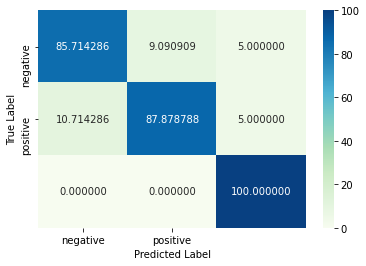

In [305]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [306]:
X_test_norm.shape

(81, 75)

In [307]:
df_t = pd.read_excel('/kaggle/input/testxlsx/Test.xlsx')
df_t = df_t.set_index('NO')
df_t = df_t.drop(['Q31'],axis = 1) 


In [308]:
yt = df_t['CLASS'].values
Xt = df_t.drop(['CLASS'],axis = 1).values

In [314]:
X_test_norm= fs.transform(Xt)

In [315]:
X_test_norm= scaler.transform(X_test_norm)

In [316]:
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(yt == y_predict)/len(yt)

0.5666666666666667